# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 315586728.84it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 114929500.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 62700737.96it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12467623.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


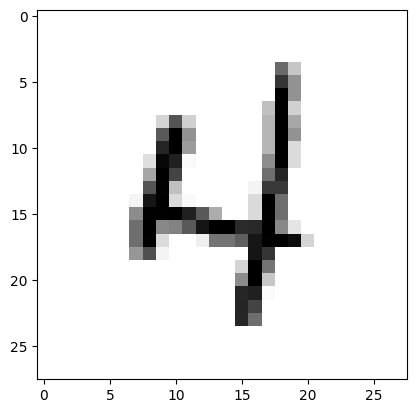

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

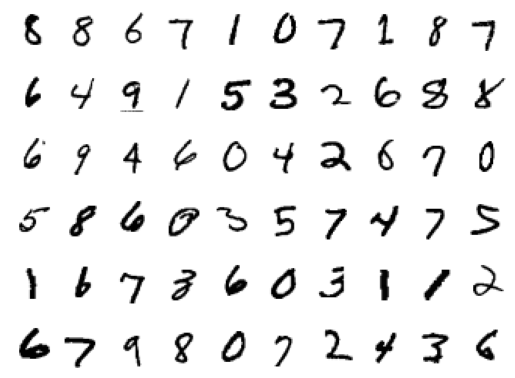

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20

# Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0721144825220108 Batch_id=468 Accuracy=94.46: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]



Test set: Average loss: 0.0585, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.043956708163022995 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]



Test set: Average loss: 0.0396, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.06169894337654114 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0347, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.015480113215744495 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]



Test set: Average loss: 0.0335, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.012525609694421291 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0360, Accuracy: 9880/10000 (98.80%)

EPOCH: 5


Loss=0.02188699133694172 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0276, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.017909785732626915 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0279, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.04786136746406555 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]



Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.00343328551389277 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0277, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.0008639299776405096 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.025632651522755623 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.05660213902592659 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.01885591633617878 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.026623697951436043 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.0275, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.0031142134685069323 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:17<00:00, 26.13it/s]



Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.016409702599048615 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.00021116051357239485 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]



Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

EPOCH: 17


Loss=0.0014518849784508348 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.004168965853750706 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.002206231467425823 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

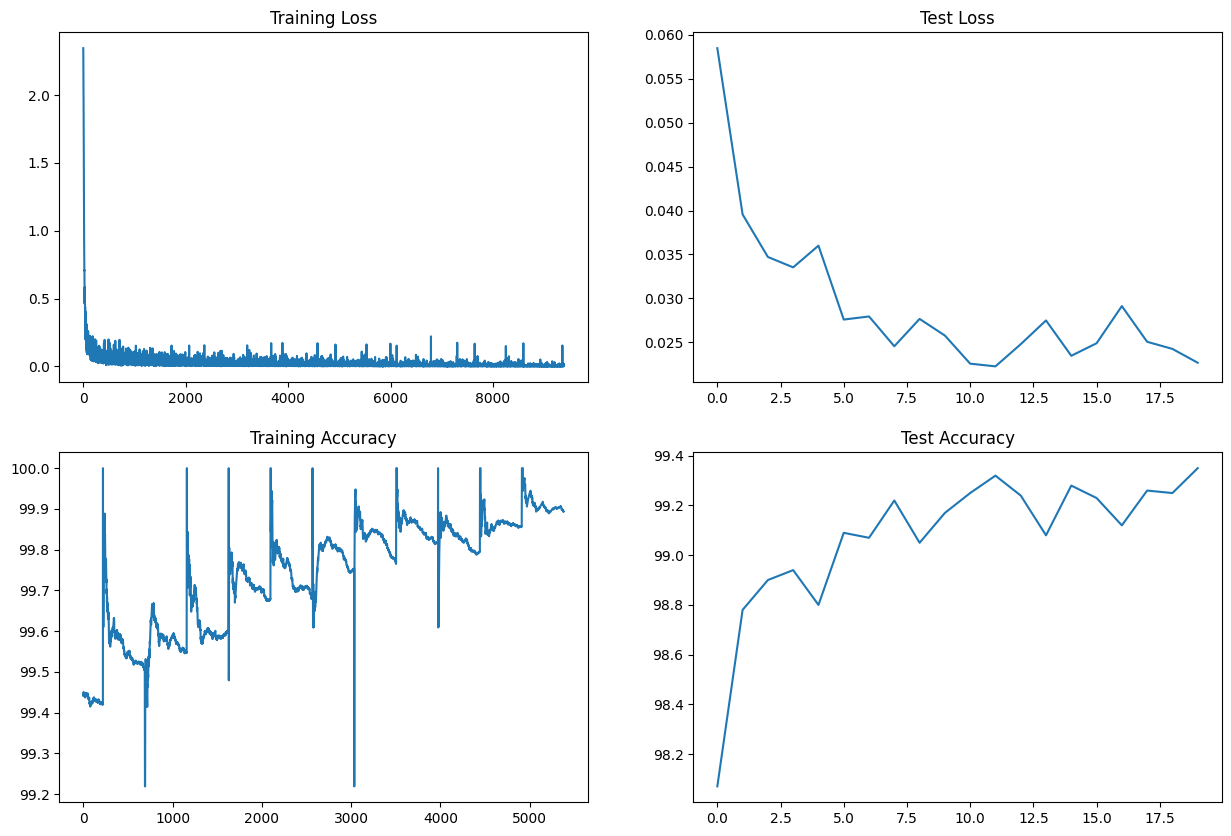

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target
  1.Add Batch-norm to increase model efficiency.

# Result
  1.Parameters: 10.9k
  2. Our Best Train Accuracy is 99.89%
  3. Our Best Test Accuracy is 99.35%

# Analysis
  1. There is overfitting in this model
  2. But overall accuracy is good for less parameters model